In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()

In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
#!ls /Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/development_mavenn2/Titeseq_16

In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-07 02:41:19.079396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize at discrete monotonic GP map

In [9]:
gpmap.set_params()
theta_0_init = np.load('models/theta_0_DM.npy')
theta_lc_init = np.load('models/theta_lc_DM.npy')

init_params_dict = {'theta_0':theta_0_init, 'theta_lc':theta_lc_init}
#gpmap.set_params(**init_params_dict)

In [10]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [11]:
print(N_y[0:10])

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
dtype: int64


#### I obtained these values from Fig 3's script

In [12]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [13]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [14]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [15]:
# mu_neg = np.log(200)
# mu_pos = np.log(9000)

#mu_neg = np.log(1.2)
mu_neg = np.log(5)
mu_pos = np.log(9000)

sigma_neg = 2.0
sigma_pos = 2.0

In [16]:
mu_neg, mu_pos

(1.6094379124341003, 9.104979856318357)

In [17]:
np.log(20000), np.log(10)

(9.903487552536127, 2.302585092994046)

In [18]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [19]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6),10**(-5.5),
     10**(-5),]

# cs = np.arange(0.1,1,0.085)
#cs = np.array(cs)*(10**6)

In [20]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         c=cs[mp_idx],
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-10,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [21]:
len(TiteSeq_mp_list)

11

In [22]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

In [23]:
#model.model.summary()

In [24]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 19.4% for validation.
Time to set data: 0.399 sec.


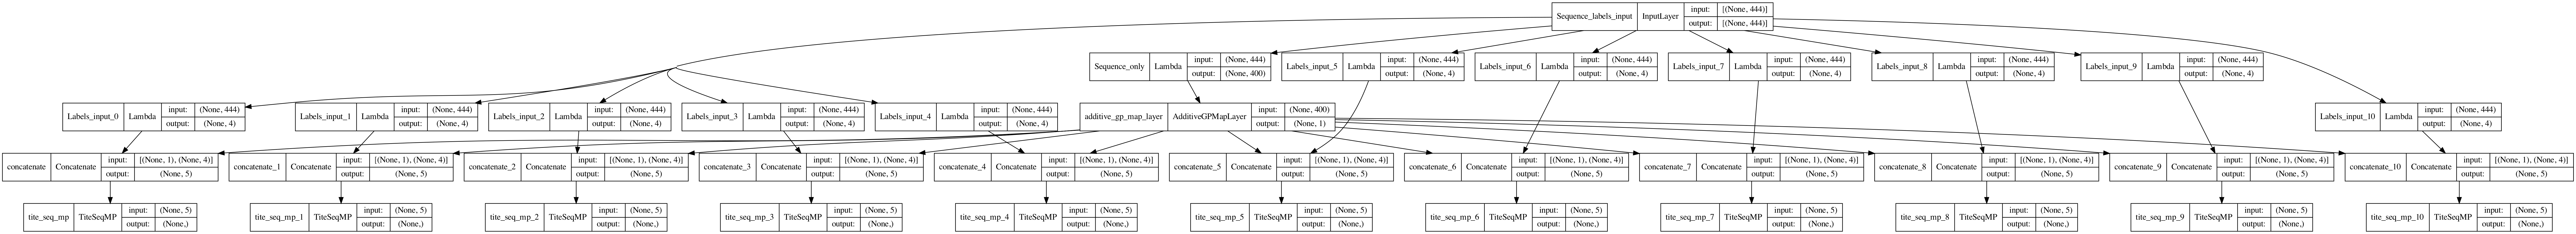

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [26]:

# Fit model to data
model.fit(learning_rate=.001,
          epochs=2000,
          batch_size=200,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/2000
43/43 [==============================] - 9s 42ms/step - loss: 8022372.0000 - tite_seq_mp_loss: 568827.7500 - tite_seq_mp_1_loss: 707159.5625 - tite_seq_mp_2_loss: 1181525.1250 - tite_seq_mp_3_loss: 898899.6875 - tite_seq_mp_4_loss: 590073.5625 - tite_seq_mp_5_loss: 309365.8125 - tite_seq_mp_6_loss: 344568.0312 - tite_seq_mp_7_loss: 1128198.6250 - tite_seq_mp_8_loss: 617742.1875 - tite_seq_mp_9_loss: 922388.7500 - tite_seq_mp_10_loss: 753622.3750 - I_var: -0.2792 - val_loss: 10661947.0000 - val_tite_seq_mp_loss: 737406.9375 - val_tite_seq_mp_1_loss: 696842.5000 - val_tite_seq_mp_2_loss: 1471474.8750 - val_tite_seq_mp_3_loss: 752189.1250 - val_tite_seq_mp_4_loss: 624901.6250 - val_tite_seq_mp_5_loss: 334778.9375 - val_tite_seq_mp_6_loss: 539663.3750 - val_tite_seq_mp_7_loss: 1133589.5000 - val_tite_seq_mp_8_loss: 1093279.0000 - val_tite_seq_mp_9_loss: 1689358.3750 - val_tite_seq_mp_10_loss: 1588461.8750 - val_I_var: -0.3286
Epoch 2/2000
43/43 [==============================]

Epoch 10/2000
43/43 [==============================] - 0s 6ms/step - loss: 7739762.5000 - tite_seq_mp_loss: 548824.5625 - tite_seq_mp_1_loss: 683193.1875 - tite_seq_mp_2_loss: 1134472.3750 - tite_seq_mp_3_loss: 861252.1875 - tite_seq_mp_4_loss: 570134.5000 - tite_seq_mp_5_loss: 300492.0000 - tite_seq_mp_6_loss: 332352.5312 - tite_seq_mp_7_loss: 1087147.7500 - tite_seq_mp_8_loss: 599734.9375 - tite_seq_mp_9_loss: 888921.1875 - tite_seq_mp_10_loss: 733237.1875 - I_var: -0.2432 - val_loss: 10244879.0000 - val_tite_seq_mp_loss: 707419.7500 - val_tite_seq_mp_1_loss: 671581.0000 - val_tite_seq_mp_2_loss: 1409281.6250 - val_tite_seq_mp_3_loss: 724715.3125 - val_tite_seq_mp_4_loss: 602828.3750 - val_tite_seq_mp_5_loss: 324662.0000 - val_tite_seq_mp_6_loss: 516688.0938 - val_tite_seq_mp_7_loss: 1090021.3750 - val_tite_seq_mp_8_loss: 1048591.5000 - val_tite_seq_mp_9_loss: 1615287.3750 - val_tite_seq_mp_10_loss: 1533801.1250 - val_I_var: -0.2831
Epoch 11/2000
43/43 [==============================

Epoch 19/2000
43/43 [==============================] - 0s 7ms/step - loss: 7605472.5000 - tite_seq_mp_loss: 537254.6875 - tite_seq_mp_1_loss: 671040.5000 - tite_seq_mp_2_loss: 1111539.8750 - tite_seq_mp_3_loss: 845247.1250 - tite_seq_mp_4_loss: 561224.0625 - tite_seq_mp_5_loss: 296918.1250 - tite_seq_mp_6_loss: 325439.4688 - tite_seq_mp_7_loss: 1072228.3750 - tite_seq_mp_8_loss: 591603.6875 - tite_seq_mp_9_loss: 868693.5625 - tite_seq_mp_10_loss: 724282.0000 - I_var: -0.2219 - val_loss: 10041065.0000 - val_tite_seq_mp_loss: 688104.7500 - val_tite_seq_mp_1_loss: 659374.0000 - val_tite_seq_mp_2_loss: 1378158.2500 - val_tite_seq_mp_3_loss: 712872.3750 - val_tite_seq_mp_4_loss: 593330.3750 - val_tite_seq_mp_5_loss: 320150.8125 - val_tite_seq_mp_6_loss: 503412.5000 - val_tite_seq_mp_7_loss: 1074062.8750 - val_tite_seq_mp_8_loss: 1028523.3750 - val_tite_seq_mp_9_loss: 1573213.0000 - val_tite_seq_mp_10_loss: 1509861.8750 - val_I_var: -0.2638
Epoch 20/2000
43/43 [==============================

Epoch 28/2000
43/43 [==============================] - 0s 6ms/step - loss: 7482196.5000 - tite_seq_mp_loss: 526643.9375 - tite_seq_mp_1_loss: 660389.3125 - tite_seq_mp_2_loss: 1090694.6250 - tite_seq_mp_3_loss: 831515.6875 - tite_seq_mp_4_loss: 553619.4375 - tite_seq_mp_5_loss: 293791.8438 - tite_seq_mp_6_loss: 318371.7188 - tite_seq_mp_7_loss: 1060372.1250 - tite_seq_mp_8_loss: 583739.8125 - tite_seq_mp_9_loss: 848239.8750 - tite_seq_mp_10_loss: 714817.9375 - I_var: -0.2117 - val_loss: 9847451.0000 - val_tite_seq_mp_loss: 668647.8750 - val_tite_seq_mp_1_loss: 647790.1250 - val_tite_seq_mp_2_loss: 1348447.6250 - val_tite_seq_mp_3_loss: 702200.8750 - val_tite_seq_mp_4_loss: 584758.0625 - val_tite_seq_mp_5_loss: 316141.3750 - val_tite_seq_mp_6_loss: 489961.4062 - val_tite_seq_mp_7_loss: 1060830.3750 - val_tite_seq_mp_8_loss: 1010237.3125 - val_tite_seq_mp_9_loss: 1530049.5000 - val_tite_seq_mp_10_loss: 1488386.3750 - val_I_var: -0.2468
Epoch 29/2000
43/43 [==============================]

Epoch 37/2000
43/43 [==============================] - 0s 5ms/step - loss: 7369352.5000 - tite_seq_mp_loss: 516087.4062 - tite_seq_mp_1_loss: 650548.9375 - tite_seq_mp_2_loss: 1070794.2500 - tite_seq_mp_3_loss: 818412.5625 - tite_seq_mp_4_loss: 546829.3125 - tite_seq_mp_5_loss: 290548.6875 - tite_seq_mp_6_loss: 312387.2812 - tite_seq_mp_7_loss: 1048143.5000 - tite_seq_mp_8_loss: 578209.1250 - tite_seq_mp_9_loss: 827959.0000 - tite_seq_mp_10_loss: 709432.6250 - I_var: -0.1988 - val_loss: 9646831.0000 - val_tite_seq_mp_loss: 648658.2500 - val_tite_seq_mp_1_loss: 635678.0000 - val_tite_seq_mp_2_loss: 1317496.7500 - val_tite_seq_mp_3_loss: 691150.4375 - val_tite_seq_mp_4_loss: 575996.8750 - val_tite_seq_mp_5_loss: 312145.7812 - val_tite_seq_mp_6_loss: 475577.3438 - val_tite_seq_mp_7_loss: 1048002.5000 - val_tite_seq_mp_8_loss: 991587.9375 - val_tite_seq_mp_9_loss: 1483810.1250 - val_tite_seq_mp_10_loss: 1466727.5000 - val_I_var: -0.2302
Epoch 38/2000
43/43 [==============================] 

Epoch 46/2000
43/43 [==============================] - 0s 5ms/step - loss: 7246075.5000 - tite_seq_mp_loss: 505906.7188 - tite_seq_mp_1_loss: 639499.0625 - tite_seq_mp_2_loss: 1048821.1250 - tite_seq_mp_3_loss: 803573.5625 - tite_seq_mp_4_loss: 539368.0625 - tite_seq_mp_5_loss: 287086.5938 - tite_seq_mp_6_loss: 305225.7500 - tite_seq_mp_7_loss: 1037305.1250 - tite_seq_mp_8_loss: 570727.7500 - tite_seq_mp_9_loss: 807192.8750 - tite_seq_mp_10_loss: 701368.1875 - I_var: -0.1815 - val_loss: 9430596.0000 - val_tite_seq_mp_loss: 629913.6250 - val_tite_seq_mp_1_loss: 622550.1875 - val_tite_seq_mp_2_loss: 1283869.2500 - val_tite_seq_mp_3_loss: 679269.6250 - val_tite_seq_mp_4_loss: 566377.0625 - val_tite_seq_mp_5_loss: 307800.8750 - val_tite_seq_mp_6_loss: 460116.3750 - val_tite_seq_mp_7_loss: 1033687.8125 - val_tite_seq_mp_8_loss: 970949.3125 - val_tite_seq_mp_9_loss: 1432885.6250 - val_tite_seq_mp_10_loss: 1443177.5000 - val_I_var: -0.2127
Epoch 47/2000
43/43 [==============================] 

Epoch 55/2000
43/43 [==============================] - 0s 5ms/step - loss: 7122240.0000 - tite_seq_mp_loss: 498215.8125 - tite_seq_mp_1_loss: 627999.8125 - tite_seq_mp_2_loss: 1026614.6250 - tite_seq_mp_3_loss: 788062.8125 - tite_seq_mp_4_loss: 531210.5625 - tite_seq_mp_5_loss: 283595.0625 - tite_seq_mp_6_loss: 298698.5625 - tite_seq_mp_7_loss: 1024902.9375 - tite_seq_mp_8_loss: 563614.2500 - tite_seq_mp_9_loss: 785826.6250 - tite_seq_mp_10_loss: 693499.1875 - I_var: -0.1655 - val_loss: 9219085.0000 - val_tite_seq_mp_loss: 613983.1875 - val_tite_seq_mp_1_loss: 609519.3125 - val_tite_seq_mp_2_loss: 1250686.3750 - val_tite_seq_mp_3_loss: 667453.5000 - val_tite_seq_mp_4_loss: 556843.0625 - val_tite_seq_mp_5_loss: 303588.4688 - val_tite_seq_mp_6_loss: 444988.6250 - val_tite_seq_mp_7_loss: 1019829.7500 - val_tite_seq_mp_8_loss: 950416.0000 - val_tite_seq_mp_9_loss: 1381601.6250 - val_tite_seq_mp_10_loss: 1420174.6250 - val_I_var: -0.1963
Epoch 56/2000
43/43 [==============================] 

Epoch 64/2000
43/43 [==============================] - 0s 5ms/step - loss: 6999625.5000 - tite_seq_mp_loss: 492978.2812 - tite_seq_mp_1_loss: 616269.1250 - tite_seq_mp_2_loss: 1004574.8750 - tite_seq_mp_3_loss: 771863.2500 - tite_seq_mp_4_loss: 523223.2812 - tite_seq_mp_5_loss: 279983.8438 - tite_seq_mp_6_loss: 292473.4688 - tite_seq_mp_7_loss: 1012216.8750 - tite_seq_mp_8_loss: 556054.6250 - tite_seq_mp_9_loss: 764640.6875 - tite_seq_mp_10_loss: 685346.5625 - I_var: -0.1561 - val_loss: 8999622.0000 - val_tite_seq_mp_loss: 601661.0000 - val_tite_seq_mp_1_loss: 595538.5000 - val_tite_seq_mp_2_loss: 1215517.6250 - val_tite_seq_mp_3_loss: 654384.3125 - val_tite_seq_mp_4_loss: 546160.7500 - val_tite_seq_mp_5_loss: 299056.1250 - val_tite_seq_mp_6_loss: 429804.7812 - val_tite_seq_mp_7_loss: 1003999.8750 - val_tite_seq_mp_8_loss: 927721.1875 - val_tite_seq_mp_9_loss: 1330821.1250 - val_tite_seq_mp_10_loss: 1394957.2500 - val_I_var: -0.1792
Epoch 65/2000
43/43 [==============================] 

Epoch 73/2000
43/43 [==============================] - 0s 5ms/step - loss: 6876788.5000 - tite_seq_mp_loss: 489187.6250 - tite_seq_mp_1_loss: 604137.5625 - tite_seq_mp_2_loss: 982739.1875 - tite_seq_mp_3_loss: 753486.1250 - tite_seq_mp_4_loss: 513839.3125 - tite_seq_mp_5_loss: 276433.9375 - tite_seq_mp_6_loss: 287167.9688 - tite_seq_mp_7_loss: 997977.3750 - tite_seq_mp_8_loss: 547935.5625 - tite_seq_mp_9_loss: 746514.6875 - tite_seq_mp_10_loss: 677369.3125 - I_var: -0.1457 - val_loss: 8795029.0000 - val_tite_seq_mp_loss: 592993.8125 - val_tite_seq_mp_1_loss: 582225.9375 - val_tite_seq_mp_2_loss: 1182422.8750 - val_tite_seq_mp_3_loss: 641595.5000 - val_tite_seq_mp_4_loss: 535632.5000 - val_tite_seq_mp_5_loss: 294715.9375 - val_tite_seq_mp_6_loss: 416219.2500 - val_tite_seq_mp_7_loss: 988178.3750 - val_tite_seq_mp_8_loss: 905405.7500 - val_tite_seq_mp_9_loss: 1284957.2500 - val_tite_seq_mp_10_loss: 1370681.3750 - val_I_var: -0.1637
Epoch 74/2000
43/43 [==============================] - 0

Epoch 82/2000
43/43 [==============================] - 0s 5ms/step - loss: 6775514.0000 - tite_seq_mp_loss: 487845.7500 - tite_seq_mp_1_loss: 594455.5000 - tite_seq_mp_2_loss: 965601.4375 - tite_seq_mp_3_loss: 738619.8750 - tite_seq_mp_4_loss: 506108.3438 - tite_seq_mp_5_loss: 273013.7812 - tite_seq_mp_6_loss: 283323.7500 - tite_seq_mp_7_loss: 984157.2500 - tite_seq_mp_8_loss: 541204.2500 - tite_seq_mp_9_loss: 731150.4375 - tite_seq_mp_10_loss: 670034.2500 - I_var: -0.1332 - val_loss: 8600864.0000 - val_tite_seq_mp_loss: 586995.0000 - val_tite_seq_mp_1_loss: 569399.5000 - val_tite_seq_mp_2_loss: 1151324.5000 - val_tite_seq_mp_3_loss: 628549.8750 - val_tite_seq_mp_4_loss: 524931.2500 - val_tite_seq_mp_5_loss: 290537.7188 - val_tite_seq_mp_6_loss: 404236.1875 - val_tite_seq_mp_7_loss: 971891.2500 - val_tite_seq_mp_8_loss: 883114.3750 - val_tite_seq_mp_9_loss: 1243388.3750 - val_tite_seq_mp_10_loss: 1346496.6250 - val_I_var: -0.1493
Epoch 83/2000
43/43 [==============================] - 0

Epoch 91/2000
43/43 [==============================] - 0s 5ms/step - loss: 6668698.5000 - tite_seq_mp_loss: 485838.0625 - tite_seq_mp_1_loss: 584397.1250 - tite_seq_mp_2_loss: 948140.6250 - tite_seq_mp_3_loss: 721678.2500 - tite_seq_mp_4_loss: 497116.5938 - tite_seq_mp_5_loss: 269456.4688 - tite_seq_mp_6_loss: 280008.6250 - tite_seq_mp_7_loss: 967937.5000 - tite_seq_mp_8_loss: 533809.6875 - tite_seq_mp_9_loss: 717798.5000 - tite_seq_mp_10_loss: 662516.1250 - I_var: -0.1277 - val_loss: 8423907.0000 - val_tite_seq_mp_loss: 583237.2500 - val_tite_seq_mp_1_loss: 557756.4375 - val_tite_seq_mp_2_loss: 1123412.2500 - val_tite_seq_mp_3_loss: 616211.0625 - val_tite_seq_mp_4_loss: 514509.4688 - val_tite_seq_mp_5_loss: 286597.5938 - val_tite_seq_mp_6_loss: 394399.8750 - val_tite_seq_mp_7_loss: 955213.6875 - val_tite_seq_mp_8_loss: 861373.0000 - val_tite_seq_mp_9_loss: 1207820.7500 - val_tite_seq_mp_10_loss: 1323375.2500 - val_I_var: -0.1367
Epoch 92/2000
43/43 [==============================] - 0

Epoch 100/2000
43/43 [==============================] - 0s 5ms/step - loss: 6589385.0000 - tite_seq_mp_loss: 486421.1250 - tite_seq_mp_1_loss: 576613.6875 - tite_seq_mp_2_loss: 935621.0625 - tite_seq_mp_3_loss: 707172.6250 - tite_seq_mp_4_loss: 489585.9375 - tite_seq_mp_5_loss: 266552.6250 - tite_seq_mp_6_loss: 278280.6875 - tite_seq_mp_7_loss: 955635.5625 - tite_seq_mp_8_loss: 527861.9375 - tite_seq_mp_9_loss: 708904.5625 - tite_seq_mp_10_loss: 656735.5000 - I_var: -0.1159 - val_loss: 8263493.5000 - val_tite_seq_mp_loss: 580821.0625 - val_tite_seq_mp_1_loss: 547290.7500 - val_tite_seq_mp_2_loss: 1098919.0000 - val_tite_seq_mp_3_loss: 604341.1250 - val_tite_seq_mp_4_loss: 504346.2812 - val_tite_seq_mp_5_loss: 282962.2500 - val_tite_seq_mp_6_loss: 386495.0625 - val_tite_seq_mp_7_loss: 938243.8125 - val_tite_seq_mp_8_loss: 840477.8125 - val_tite_seq_mp_9_loss: 1178296.8750 - val_tite_seq_mp_10_loss: 1301300.0000 - val_I_var: -0.1259
Epoch 101/2000
43/43 [==============================] -

Epoch 109/2000
43/43 [==============================] - 0s 5ms/step - loss: 6513357.0000 - tite_seq_mp_loss: 486391.0625 - tite_seq_mp_1_loss: 569957.0625 - tite_seq_mp_2_loss: 925630.1250 - tite_seq_mp_3_loss: 692510.8125 - tite_seq_mp_4_loss: 482432.7188 - tite_seq_mp_5_loss: 264052.8125 - tite_seq_mp_6_loss: 277020.0312 - tite_seq_mp_7_loss: 941334.0625 - tite_seq_mp_8_loss: 522521.2500 - tite_seq_mp_9_loss: 700875.0000 - tite_seq_mp_10_loss: 650633.0000 - I_var: -0.1139 - val_loss: 8125513.5000 - val_tite_seq_mp_loss: 579438.4375 - val_tite_seq_mp_1_loss: 538592.3125 - val_tite_seq_mp_2_loss: 1078509.5000 - val_tite_seq_mp_3_loss: 593903.3750 - val_tite_seq_mp_4_loss: 495067.1562 - val_tite_seq_mp_5_loss: 279726.3438 - val_tite_seq_mp_6_loss: 380691.1875 - val_tite_seq_mp_7_loss: 921518.0000 - val_tite_seq_mp_8_loss: 821266.8750 - val_tite_seq_mp_9_loss: 1155103.8750 - val_tite_seq_mp_10_loss: 1281696.3750 - val_I_var: -0.1172
Epoch 110/2000
43/43 [==============================] -

Epoch 118/2000
43/43 [==============================] - 0s 6ms/step - loss: 6428376.5000 - tite_seq_mp_loss: 487643.0625 - tite_seq_mp_1_loss: 562829.8125 - tite_seq_mp_2_loss: 912204.9375 - tite_seq_mp_3_loss: 677590.7500 - tite_seq_mp_4_loss: 474153.9688 - tite_seq_mp_5_loss: 261239.1875 - tite_seq_mp_6_loss: 275163.7812 - tite_seq_mp_7_loss: 926988.1250 - tite_seq_mp_8_loss: 514978.5312 - tite_seq_mp_9_loss: 693001.6250 - tite_seq_mp_10_loss: 642583.1875 - I_var: -0.1002 - val_loss: 7992124.0000 - val_tite_seq_mp_loss: 580587.6875 - val_tite_seq_mp_1_loss: 529911.5000 - val_tite_seq_mp_2_loss: 1058193.8750 - val_tite_seq_mp_3_loss: 581897.1875 - val_tite_seq_mp_4_loss: 485196.2812 - val_tite_seq_mp_5_loss: 276579.0938 - val_tite_seq_mp_6_loss: 375166.3125 - val_tite_seq_mp_7_loss: 905029.3125 - val_tite_seq_mp_8_loss: 802339.6250 - val_tite_seq_mp_9_loss: 1134786.6250 - val_tite_seq_mp_10_loss: 1262435.7500 - val_I_var: -0.1034
Epoch 119/2000
43/43 [==============================] -

Epoch 127/2000
43/43 [==============================] - 0s 5ms/step - loss: 6341171.5000 - tite_seq_mp_loss: 498402.6562 - tite_seq_mp_1_loss: 556262.0625 - tite_seq_mp_2_loss: 894677.1250 - tite_seq_mp_3_loss: 660454.3750 - tite_seq_mp_4_loss: 465543.6875 - tite_seq_mp_5_loss: 258383.9375 - tite_seq_mp_6_loss: 271860.4688 - tite_seq_mp_7_loss: 917685.1250 - tite_seq_mp_8_loss: 507356.9062 - tite_seq_mp_9_loss: 678662.8125 - tite_seq_mp_10_loss: 631881.3750 - I_var: -0.0640 - val_loss: 7858399.5000 - val_tite_seq_mp_loss: 590208.9375 - val_tite_seq_mp_1_loss: 520488.2812 - val_tite_seq_mp_2_loss: 1035372.4375 - val_tite_seq_mp_3_loss: 565337.2500 - val_tite_seq_mp_4_loss: 474437.0938 - val_tite_seq_mp_5_loss: 273281.5000 - val_tite_seq_mp_6_loss: 367240.0000 - val_tite_seq_mp_7_loss: 892987.6250 - val_tite_seq_mp_8_loss: 784320.6875 - val_tite_seq_mp_9_loss: 1111854.1250 - val_tite_seq_mp_10_loss: 1242870.5000 - val_I_var: -0.0645
Epoch 128/2000
43/43 [==============================] -

Epoch 136/2000
43/43 [==============================] - 0s 5ms/step - loss: 6249201.0000 - tite_seq_mp_loss: 501903.4062 - tite_seq_mp_1_loss: 548819.6875 - tite_seq_mp_2_loss: 880746.1875 - tite_seq_mp_3_loss: 643313.4375 - tite_seq_mp_4_loss: 456066.4375 - tite_seq_mp_5_loss: 254995.4688 - tite_seq_mp_6_loss: 269645.8750 - tite_seq_mp_7_loss: 901487.6250 - tite_seq_mp_8_loss: 499279.4375 - tite_seq_mp_9_loss: 669969.6875 - tite_seq_mp_10_loss: 622973.6250 - I_var: -0.0429 - val_loss: 7704024.0000 - val_tite_seq_mp_loss: 592099.5625 - val_tite_seq_mp_1_loss: 511142.2500 - val_tite_seq_mp_2_loss: 1012106.4375 - val_tite_seq_mp_3_loss: 551289.3125 - val_tite_seq_mp_4_loss: 462799.0312 - val_tite_seq_mp_5_loss: 269372.2500 - val_tite_seq_mp_6_loss: 360054.8438 - val_tite_seq_mp_7_loss: 873821.2500 - val_tite_seq_mp_8_loss: 761751.6250 - val_tite_seq_mp_9_loss: 1091030.6250 - val_tite_seq_mp_10_loss: 1218555.3750 - val_I_var: -0.0431
Epoch 137/2000
43/43 [==============================] -

Epoch 145/2000
43/43 [==============================] - 0s 6ms/step - loss: 6165965.0000 - tite_seq_mp_loss: 504655.9688 - tite_seq_mp_1_loss: 542496.8125 - tite_seq_mp_2_loss: 869192.8125 - tite_seq_mp_3_loss: 626801.1250 - tite_seq_mp_4_loss: 447100.2500 - tite_seq_mp_5_loss: 251888.7031 - tite_seq_mp_6_loss: 267849.4688 - tite_seq_mp_7_loss: 886199.0000 - tite_seq_mp_8_loss: 492355.1875 - tite_seq_mp_9_loss: 663312.5000 - tite_seq_mp_10_loss: 614110.7500 - I_var: -0.0234 - val_loss: 7559962.0000 - val_tite_seq_mp_loss: 594400.7500 - val_tite_seq_mp_1_loss: 502673.9062 - val_tite_seq_mp_2_loss: 991309.8125 - val_tite_seq_mp_3_loss: 537938.3125 - val_tite_seq_mp_4_loss: 451612.7812 - val_tite_seq_mp_5_loss: 265647.0625 - val_tite_seq_mp_6_loss: 353791.1875 - val_tite_seq_mp_7_loss: 855068.8125 - val_tite_seq_mp_8_loss: 740340.5625 - val_tite_seq_mp_9_loss: 1072047.1250 - val_tite_seq_mp_10_loss: 1195131.0000 - val_I_var: -0.0211
Epoch 146/2000
43/43 [==============================] - 

Epoch 154/2000
43/43 [==============================] - 0s 7ms/step - loss: 6086374.0000 - tite_seq_mp_loss: 507480.9375 - tite_seq_mp_1_loss: 536659.8125 - tite_seq_mp_2_loss: 859371.8750 - tite_seq_mp_3_loss: 611401.1250 - tite_seq_mp_4_loss: 438377.1562 - tite_seq_mp_5_loss: 248805.1719 - tite_seq_mp_6_loss: 266029.3750 - tite_seq_mp_7_loss: 870647.1250 - tite_seq_mp_8_loss: 485637.0312 - tite_seq_mp_9_loss: 657008.3125 - tite_seq_mp_10_loss: 604954.9375 - I_var: -0.0052 - val_loss: 7429825.0000 - val_tite_seq_mp_loss: 596760.0000 - val_tite_seq_mp_1_loss: 495130.6562 - val_tite_seq_mp_2_loss: 973054.1250 - val_tite_seq_mp_3_loss: 525785.3750 - val_tite_seq_mp_4_loss: 441115.0938 - val_tite_seq_mp_5_loss: 262158.8750 - val_tite_seq_mp_6_loss: 348466.9062 - val_tite_seq_mp_7_loss: 837083.8750 - val_tite_seq_mp_8_loss: 720465.5000 - val_tite_seq_mp_9_loss: 1056397.1250 - val_tite_seq_mp_10_loss: 1173406.5000 - val_I_var: 6.9891e-04
Epoch 155/2000
43/43 [==============================]

Epoch 163/2000
43/43 [==============================] - 0s 6ms/step - loss: 6017961.0000 - tite_seq_mp_loss: 509727.9375 - tite_seq_mp_1_loss: 531878.8125 - tite_seq_mp_2_loss: 851427.3125 - tite_seq_mp_3_loss: 597885.3125 - tite_seq_mp_4_loss: 430840.6562 - tite_seq_mp_5_loss: 245843.2344 - tite_seq_mp_6_loss: 264652.8750 - tite_seq_mp_7_loss: 856631.8125 - tite_seq_mp_8_loss: 479780.7812 - tite_seq_mp_9_loss: 651981.1250 - tite_seq_mp_10_loss: 597311.2500 - I_var: 0.0124 - val_loss: 7306438.5000 - val_tite_seq_mp_loss: 598666.3750 - val_tite_seq_mp_1_loss: 488083.1875 - val_tite_seq_mp_2_loss: 956739.2500 - val_tite_seq_mp_3_loss: 514167.8438 - val_tite_seq_mp_4_loss: 430838.0000 - val_tite_seq_mp_5_loss: 258837.5781 - val_tite_seq_mp_6_loss: 343623.1875 - val_tite_seq_mp_7_loss: 818997.0000 - val_tite_seq_mp_8_loss: 701460.0625 - val_tite_seq_mp_9_loss: 1042876.3750 - val_tite_seq_mp_10_loss: 1152148.2500 - val_I_var: 0.0212
Epoch 164/2000
43/43 [==============================] - 0s

Epoch 172/2000
43/43 [==============================] - 0s 6ms/step - loss: 5951277.0000 - tite_seq_mp_loss: 512710.9375 - tite_seq_mp_1_loss: 527609.1250 - tite_seq_mp_2_loss: 844606.5000 - tite_seq_mp_3_loss: 585193.3125 - tite_seq_mp_4_loss: 423004.7188 - tite_seq_mp_5_loss: 243177.5156 - tite_seq_mp_6_loss: 263375.2500 - tite_seq_mp_7_loss: 841656.5000 - tite_seq_mp_8_loss: 474033.6875 - tite_seq_mp_9_loss: 647218.7500 - tite_seq_mp_10_loss: 588689.6875 - I_var: 0.0300 - val_loss: 7195550.5000 - val_tite_seq_mp_loss: 601051.5625 - val_tite_seq_mp_1_loss: 481979.7188 - val_tite_seq_mp_2_loss: 942254.7500 - val_tite_seq_mp_3_loss: 503959.2188 - val_tite_seq_mp_4_loss: 421326.3438 - val_tite_seq_mp_5_loss: 255772.7031 - val_tite_seq_mp_6_loss: 339796.5938 - val_tite_seq_mp_7_loss: 801502.8125 - val_tite_seq_mp_8_loss: 683614.8750 - val_tite_seq_mp_9_loss: 1031539.0625 - val_tite_seq_mp_10_loss: 1132752.1250 - val_I_var: 0.0417
Epoch 173/2000
43/43 [==============================] - 0s

Epoch 181/2000
43/43 [==============================] - 0s 6ms/step - loss: 5895654.0000 - tite_seq_mp_loss: 515305.6562 - tite_seq_mp_1_loss: 524194.4062 - tite_seq_mp_2_loss: 839776.2500 - tite_seq_mp_3_loss: 573730.4375 - tite_seq_mp_4_loss: 416078.1562 - tite_seq_mp_5_loss: 240959.7969 - tite_seq_mp_6_loss: 262431.6562 - tite_seq_mp_7_loss: 828354.1875 - tite_seq_mp_8_loss: 469001.6875 - tite_seq_mp_9_loss: 643879.3125 - tite_seq_mp_10_loss: 581942.1875 - I_var: 0.0464 - val_loss: 7087643.0000 - val_tite_seq_mp_loss: 602072.1875 - val_tite_seq_mp_1_loss: 476196.1562 - val_tite_seq_mp_2_loss: 929364.0625 - val_tite_seq_mp_3_loss: 494116.5312 - val_tite_seq_mp_4_loss: 411943.7812 - val_tite_seq_mp_5_loss: 252858.7344 - val_tite_seq_mp_6_loss: 335949.0938 - val_tite_seq_mp_7_loss: 783479.8125 - val_tite_seq_mp_8_loss: 666495.7500 - val_tite_seq_mp_9_loss: 1021498.8750 - val_tite_seq_mp_10_loss: 1113665.8750 - val_I_var: 0.0579
Epoch 182/2000
43/43 [==============================] - 0s

Epoch 190/2000
43/43 [==============================] - 0s 6ms/step - loss: 5835408.0000 - tite_seq_mp_loss: 517013.4375 - tite_seq_mp_1_loss: 520667.0938 - tite_seq_mp_2_loss: 835090.1250 - tite_seq_mp_3_loss: 562584.6250 - tite_seq_mp_4_loss: 408659.8125 - tite_seq_mp_5_loss: 238285.3125 - tite_seq_mp_6_loss: 261556.4531 - tite_seq_mp_7_loss: 814423.6875 - tite_seq_mp_8_loss: 463944.9688 - tite_seq_mp_9_loss: 639920.2500 - tite_seq_mp_10_loss: 573261.3750 - I_var: 0.0593 - val_loss: 6994314.0000 - val_tite_seq_mp_loss: 604088.3125 - val_tite_seq_mp_1_loss: 471259.8125 - val_tite_seq_mp_2_loss: 918835.5000 - val_tite_seq_mp_3_loss: 485373.4062 - val_tite_seq_mp_4_loss: 403392.0938 - val_tite_seq_mp_5_loss: 250308.3125 - val_tite_seq_mp_6_loss: 332948.4062 - val_tite_seq_mp_7_loss: 767054.9375 - val_tite_seq_mp_8_loss: 651381.6250 - val_tite_seq_mp_9_loss: 1013107.5000 - val_tite_seq_mp_10_loss: 1096562.2500 - val_I_var: 0.0758
Epoch 191/2000
43/43 [==============================] - 0s

Epoch 199/2000
43/43 [==============================] - 0s 5ms/step - loss: 5786880.0000 - tite_seq_mp_loss: 518482.8750 - tite_seq_mp_1_loss: 517893.5000 - tite_seq_mp_2_loss: 831313.2500 - tite_seq_mp_3_loss: 552515.7500 - tite_seq_mp_4_loss: 402480.7812 - tite_seq_mp_5_loss: 236261.3125 - tite_seq_mp_6_loss: 260932.9688 - tite_seq_mp_7_loss: 801020.3125 - tite_seq_mp_8_loss: 460033.5625 - tite_seq_mp_9_loss: 638171.3750 - tite_seq_mp_10_loss: 567772.5625 - I_var: 0.0704 - val_loss: 6903948.5000 - val_tite_seq_mp_loss: 605437.2500 - val_tite_seq_mp_1_loss: 466810.7812 - val_tite_seq_mp_2_loss: 908836.8750 - val_tite_seq_mp_3_loss: 477478.1250 - val_tite_seq_mp_4_loss: 395045.8438 - val_tite_seq_mp_5_loss: 247873.2500 - val_tite_seq_mp_6_loss: 330360.5938 - val_tite_seq_mp_7_loss: 749636.8750 - val_tite_seq_mp_8_loss: 636336.5625 - val_tite_seq_mp_9_loss: 1006088.8750 - val_tite_seq_mp_10_loss: 1080041.7500 - val_I_var: 0.0901
Epoch 200/2000
43/43 [==============================] - 0s

Epoch 208/2000
43/43 [==============================] - 0s 9ms/step - loss: 5746634.0000 - tite_seq_mp_loss: 520438.3750 - tite_seq_mp_1_loss: 515904.5625 - tite_seq_mp_2_loss: 828849.7500 - tite_seq_mp_3_loss: 544901.2500 - tite_seq_mp_4_loss: 397067.7500 - tite_seq_mp_5_loss: 234471.9531 - tite_seq_mp_6_loss: 260570.9844 - tite_seq_mp_7_loss: 789297.8750 - tite_seq_mp_8_loss: 456623.9062 - tite_seq_mp_9_loss: 636130.6250 - tite_seq_mp_10_loss: 562377.1250 - I_var: 0.0807 - val_loss: 6825940.5000 - val_tite_seq_mp_loss: 607125.5625 - val_tite_seq_mp_1_loss: 463031.6250 - val_tite_seq_mp_2_loss: 900976.5000 - val_tite_seq_mp_3_loss: 470488.4688 - val_tite_seq_mp_4_loss: 387522.9375 - val_tite_seq_mp_5_loss: 245802.9219 - val_tite_seq_mp_6_loss: 328160.6875 - val_tite_seq_mp_7_loss: 733923.0625 - val_tite_seq_mp_8_loss: 623331.3750 - val_tite_seq_mp_9_loss: 1000167.5000 - val_tite_seq_mp_10_loss: 1065408.1250 - val_I_var: 0.1047
Epoch 209/2000
43/43 [==============================] - 0s

Epoch 217/2000
43/43 [==============================] - 0s 5ms/step - loss: 5706373.0000 - tite_seq_mp_loss: 522045.7188 - tite_seq_mp_1_loss: 514355.9062 - tite_seq_mp_2_loss: 826787.8125 - tite_seq_mp_3_loss: 536959.3125 - tite_seq_mp_4_loss: 391794.7188 - tite_seq_mp_5_loss: 232529.9688 - tite_seq_mp_6_loss: 260092.6406 - tite_seq_mp_7_loss: 777849.0625 - tite_seq_mp_8_loss: 453445.1250 - tite_seq_mp_9_loss: 633758.0625 - tite_seq_mp_10_loss: 556751.3125 - I_var: 0.0943 - val_loss: 6756467.5000 - val_tite_seq_mp_loss: 608682.8125 - val_tite_seq_mp_1_loss: 459842.4375 - val_tite_seq_mp_2_loss: 894267.8750 - val_tite_seq_mp_3_loss: 464409.3438 - val_tite_seq_mp_4_loss: 380687.1875 - val_tite_seq_mp_5_loss: 244004.5000 - val_tite_seq_mp_6_loss: 326262.9062 - val_tite_seq_mp_7_loss: 719030.4375 - val_tite_seq_mp_8_loss: 611561.3125 - val_tite_seq_mp_9_loss: 995315.5000 - val_tite_seq_mp_10_loss: 1052401.3750 - val_I_var: 0.1176
Epoch 218/2000
43/43 [==============================] - 0s 

Epoch 226/2000
43/43 [==============================] - 0s 10ms/step - loss: 5666718.0000 - tite_seq_mp_loss: 523402.2500 - tite_seq_mp_1_loss: 512390.1250 - tite_seq_mp_2_loss: 825398.7500 - tite_seq_mp_3_loss: 530561.8125 - tite_seq_mp_4_loss: 387004.3750 - tite_seq_mp_5_loss: 230530.7969 - tite_seq_mp_6_loss: 259222.7812 - tite_seq_mp_7_loss: 765825.5625 - tite_seq_mp_8_loss: 450326.8750 - tite_seq_mp_9_loss: 631572.6875 - tite_seq_mp_10_loss: 550480.1250 - I_var: 0.1058 - val_loss: 6694250.0000 - val_tite_seq_mp_loss: 610211.3750 - val_tite_seq_mp_1_loss: 457160.0000 - val_tite_seq_mp_2_loss: 888554.3750 - val_tite_seq_mp_3_loss: 459165.5312 - val_tite_seq_mp_4_loss: 374509.0625 - val_tite_seq_mp_5_loss: 242470.3906 - val_tite_seq_mp_6_loss: 324622.5938 - val_tite_seq_mp_7_loss: 705092.6875 - val_tite_seq_mp_8_loss: 600957.5000 - val_tite_seq_mp_9_loss: 990689.3750 - val_tite_seq_mp_10_loss: 1040815.2500 - val_I_var: 0.1295
Epoch 227/2000
43/43 [==============================] - 1s

Epoch 235/2000
43/43 [==============================] - 0s 7ms/step - loss: 5643631.0000 - tite_seq_mp_loss: 525638.5625 - tite_seq_mp_1_loss: 511698.0312 - tite_seq_mp_2_loss: 824431.0625 - tite_seq_mp_3_loss: 525666.5625 - tite_seq_mp_4_loss: 383015.2188 - tite_seq_mp_5_loss: 229642.0781 - tite_seq_mp_6_loss: 259404.3594 - tite_seq_mp_7_loss: 758723.8125 - tite_seq_mp_8_loss: 448308.9375 - tite_seq_mp_9_loss: 630352.3750 - tite_seq_mp_10_loss: 546747.0000 - I_var: 0.1114 - val_loss: 6642604.0000 - val_tite_seq_mp_loss: 611700.8125 - val_tite_seq_mp_1_loss: 454947.2812 - val_tite_seq_mp_2_loss: 884436.6875 - val_tite_seq_mp_3_loss: 454634.2500 - val_tite_seq_mp_4_loss: 369121.9062 - val_tite_seq_mp_5_loss: 241237.1719 - val_tite_seq_mp_6_loss: 323166.0000 - val_tite_seq_mp_7_loss: 692987.9375 - val_tite_seq_mp_8_loss: 592274.8125 - val_tite_seq_mp_9_loss: 987127.2500 - val_tite_seq_mp_10_loss: 1030967.1875 - val_I_var: 0.1409
Epoch 236/2000
43/43 [==============================] - 0s 

43/43 [==============================] - 0s 7ms/step - loss: 5619836.0000 - tite_seq_mp_loss: 525927.3750 - tite_seq_mp_1_loss: 510948.4375 - tite_seq_mp_2_loss: 824543.3750 - tite_seq_mp_3_loss: 521299.2188 - tite_seq_mp_4_loss: 379678.4375 - tite_seq_mp_5_loss: 228487.7812 - tite_seq_mp_6_loss: 259124.3438 - tite_seq_mp_7_loss: 750376.4375 - tite_seq_mp_8_loss: 446782.4375 - tite_seq_mp_9_loss: 629413.1875 - tite_seq_mp_10_loss: 543252.5000 - I_var: 0.1187 - val_loss: 6594320.5000 - val_tite_seq_mp_loss: 612452.0000 - val_tite_seq_mp_1_loss: 453215.2188 - val_tite_seq_mp_2_loss: 879677.1250 - val_tite_seq_mp_3_loss: 451216.6250 - val_tite_seq_mp_4_loss: 364404.1875 - val_tite_seq_mp_5_loss: 240198.3594 - val_tite_seq_mp_6_loss: 321981.8438 - val_tite_seq_mp_7_loss: 680948.4375 - val_tite_seq_mp_8_loss: 583665.0000 - val_tite_seq_mp_9_loss: 983997.3125 - val_tite_seq_mp_10_loss: 1022562.0000 - val_I_var: 0.1471
Epoch 244/2000
43/43 [==============================] - 0s 6ms/step - loss

Epoch 252/2000
43/43 [==============================] - 0s 6ms/step - loss: 5601982.5000 - tite_seq_mp_loss: 528077.7500 - tite_seq_mp_1_loss: 510640.7188 - tite_seq_mp_2_loss: 824361.6875 - tite_seq_mp_3_loss: 517584.8125 - tite_seq_mp_4_loss: 376769.1562 - tite_seq_mp_5_loss: 227726.1719 - tite_seq_mp_6_loss: 259090.7500 - tite_seq_mp_7_loss: 743230.4375 - tite_seq_mp_8_loss: 445079.2500 - tite_seq_mp_9_loss: 629043.9375 - tite_seq_mp_10_loss: 540375.0000 - I_var: 0.1230 - val_loss: 6552060.0000 - val_tite_seq_mp_loss: 613764.0000 - val_tite_seq_mp_1_loss: 451580.1250 - val_tite_seq_mp_2_loss: 876805.0625 - val_tite_seq_mp_3_loss: 447683.5625 - val_tite_seq_mp_4_loss: 359837.6875 - val_tite_seq_mp_5_loss: 239315.9062 - val_tite_seq_mp_6_loss: 320813.4062 - val_tite_seq_mp_7_loss: 669929.0000 - val_tite_seq_mp_8_loss: 576429.0000 - val_tite_seq_mp_9_loss: 981380.2500 - val_tite_seq_mp_10_loss: 1014519.6875 - val_I_var: 0.1562
Epoch 253/2000
43/43 [==============================] - 0s 

Epoch 261/2000
43/43 [==============================] - 0s 6ms/step - loss: 5580865.0000 - tite_seq_mp_loss: 528979.5625 - tite_seq_mp_1_loss: 510051.2188 - tite_seq_mp_2_loss: 824141.5625 - tite_seq_mp_3_loss: 514112.8125 - tite_seq_mp_4_loss: 373672.6250 - tite_seq_mp_5_loss: 226696.4219 - tite_seq_mp_6_loss: 258985.9531 - tite_seq_mp_7_loss: 736561.3750 - tite_seq_mp_8_loss: 443422.7188 - tite_seq_mp_9_loss: 627582.1250 - tite_seq_mp_10_loss: 536656.0625 - I_var: 0.1355 - val_loss: 6512830.5000 - val_tite_seq_mp_loss: 614460.4375 - val_tite_seq_mp_1_loss: 450202.2188 - val_tite_seq_mp_2_loss: 873521.8750 - val_tite_seq_mp_3_loss: 444888.6562 - val_tite_seq_mp_4_loss: 355880.9688 - val_tite_seq_mp_5_loss: 238626.2969 - val_tite_seq_mp_6_loss: 319522.1875 - val_tite_seq_mp_7_loss: 659637.2500 - val_tite_seq_mp_8_loss: 569704.2500 - val_tite_seq_mp_9_loss: 978557.1875 - val_tite_seq_mp_10_loss: 1007826.3750 - val_I_var: 0.1622
Epoch 262/2000
43/43 [==============================] - 0s 

Epoch 270/2000
43/43 [==============================] - 0s 6ms/step - loss: 5565740.5000 - tite_seq_mp_loss: 530130.0000 - tite_seq_mp_1_loss: 509631.5000 - tite_seq_mp_2_loss: 823909.9375 - tite_seq_mp_3_loss: 511509.8125 - tite_seq_mp_4_loss: 371380.2188 - tite_seq_mp_5_loss: 226158.7188 - tite_seq_mp_6_loss: 258907.4062 - tite_seq_mp_7_loss: 731068.9375 - tite_seq_mp_8_loss: 442474.5312 - tite_seq_mp_9_loss: 626362.5000 - tite_seq_mp_10_loss: 534203.8750 - I_var: 0.1368 - val_loss: 6479343.0000 - val_tite_seq_mp_loss: 615478.4375 - val_tite_seq_mp_1_loss: 449147.5312 - val_tite_seq_mp_2_loss: 870998.1875 - val_tite_seq_mp_3_loss: 442491.9688 - val_tite_seq_mp_4_loss: 352259.5625 - val_tite_seq_mp_5_loss: 238091.1875 - val_tite_seq_mp_6_loss: 318670.3125 - val_tite_seq_mp_7_loss: 650257.8125 - val_tite_seq_mp_8_loss: 563733.0625 - val_tite_seq_mp_9_loss: 976419.0000 - val_tite_seq_mp_10_loss: 1001793.6875 - val_I_var: 0.1685
Epoch 271/2000
43/43 [==============================] - 0s 

Epoch 279/2000
43/43 [==============================] - 0s 8ms/step - loss: 5554141.5000 - tite_seq_mp_loss: 530761.7500 - tite_seq_mp_1_loss: 509556.6875 - tite_seq_mp_2_loss: 824876.0625 - tite_seq_mp_3_loss: 509548.6875 - tite_seq_mp_4_loss: 369318.3438 - tite_seq_mp_5_loss: 225565.0312 - tite_seq_mp_6_loss: 259055.3125 - tite_seq_mp_7_loss: 726598.4375 - tite_seq_mp_8_loss: 441560.1562 - tite_seq_mp_9_loss: 625857.0625 - tite_seq_mp_10_loss: 531441.8750 - I_var: 0.1454 - val_loss: 6451165.0000 - val_tite_seq_mp_loss: 616348.8750 - val_tite_seq_mp_1_loss: 448256.1250 - val_tite_seq_mp_2_loss: 869099.1250 - val_tite_seq_mp_3_loss: 440466.6250 - val_tite_seq_mp_4_loss: 349176.0938 - val_tite_seq_mp_5_loss: 237713.9375 - val_tite_seq_mp_6_loss: 317799.2188 - val_tite_seq_mp_7_loss: 642270.6875 - val_tite_seq_mp_8_loss: 558812.3125 - val_tite_seq_mp_9_loss: 974418.3750 - val_tite_seq_mp_10_loss: 996800.1875 - val_I_var: 0.1744
Epoch 280/2000
43/43 [==============================] - 0s 7

Epoch 288/2000
43/43 [==============================] - 0s 6ms/step - loss: 5541566.0000 - tite_seq_mp_loss: 531839.3125 - tite_seq_mp_1_loss: 509015.3438 - tite_seq_mp_2_loss: 825117.7500 - tite_seq_mp_3_loss: 507362.0000 - tite_seq_mp_4_loss: 367330.2500 - tite_seq_mp_5_loss: 224812.7031 - tite_seq_mp_6_loss: 258903.4062 - tite_seq_mp_7_loss: 721839.3750 - tite_seq_mp_8_loss: 440478.5000 - tite_seq_mp_9_loss: 625138.0625 - tite_seq_mp_10_loss: 529726.1875 - I_var: 0.1475 - val_loss: 6428143.5000 - val_tite_seq_mp_loss: 617299.5000 - val_tite_seq_mp_1_loss: 447559.2500 - val_tite_seq_mp_2_loss: 867929.8750 - val_tite_seq_mp_3_loss: 438730.4062 - val_tite_seq_mp_4_loss: 346498.5938 - val_tite_seq_mp_5_loss: 237446.6875 - val_tite_seq_mp_6_loss: 317131.1562 - val_tite_seq_mp_7_loss: 635456.1250 - val_tite_seq_mp_8_loss: 554828.1875 - val_tite_seq_mp_9_loss: 972727.1875 - val_tite_seq_mp_10_loss: 992534.0625 - val_I_var: 0.1805
Epoch 289/2000
43/43 [==============================] - 0s 6

Epoch 297/2000
43/43 [==============================] - 0s 7ms/step - loss: 5535140.0000 - tite_seq_mp_loss: 532573.1875 - tite_seq_mp_1_loss: 509238.2188 - tite_seq_mp_2_loss: 826046.8750 - tite_seq_mp_3_loss: 506249.3750 - tite_seq_mp_4_loss: 366167.5938 - tite_seq_mp_5_loss: 224696.5312 - tite_seq_mp_6_loss: 259144.1719 - tite_seq_mp_7_loss: 718940.5000 - tite_seq_mp_8_loss: 440029.0625 - tite_seq_mp_9_loss: 624421.2500 - tite_seq_mp_10_loss: 527630.0625 - I_var: 0.1551 - val_loss: 6407633.5000 - val_tite_seq_mp_loss: 618066.6875 - val_tite_seq_mp_1_loss: 446977.5000 - val_tite_seq_mp_2_loss: 866728.9375 - val_tite_seq_mp_3_loss: 437306.8750 - val_tite_seq_mp_4_loss: 344144.0625 - val_tite_seq_mp_5_loss: 237279.1562 - val_tite_seq_mp_6_loss: 316496.4375 - val_tite_seq_mp_7_loss: 629266.9375 - val_tite_seq_mp_8_loss: 551150.6250 - val_tite_seq_mp_9_loss: 971297.8125 - val_tite_seq_mp_10_loss: 988915.4375 - val_I_var: 0.1852
Epoch 298/2000
43/43 [==============================] - 0s 8

Epoch 306/2000
43/43 [==============================] - 0s 6ms/step - loss: 5527129.0000 - tite_seq_mp_loss: 533361.2500 - tite_seq_mp_1_loss: 509206.1250 - tite_seq_mp_2_loss: 826145.8125 - tite_seq_mp_3_loss: 505099.0625 - tite_seq_mp_4_loss: 364707.0000 - tite_seq_mp_5_loss: 224418.7812 - tite_seq_mp_6_loss: 259094.2344 - tite_seq_mp_7_loss: 716412.3750 - tite_seq_mp_8_loss: 439389.9688 - tite_seq_mp_9_loss: 623577.9375 - tite_seq_mp_10_loss: 525714.8125 - I_var: 0.1581 - val_loss: 6390654.5000 - val_tite_seq_mp_loss: 619108.6875 - val_tite_seq_mp_1_loss: 446704.3438 - val_tite_seq_mp_2_loss: 865937.5625 - val_tite_seq_mp_3_loss: 436137.3438 - val_tite_seq_mp_4_loss: 341998.5625 - val_tite_seq_mp_5_loss: 237177.5000 - val_tite_seq_mp_6_loss: 316295.4688 - val_tite_seq_mp_7_loss: 623727.2500 - val_tite_seq_mp_8_loss: 547766.5000 - val_tite_seq_mp_9_loss: 970222.5000 - val_tite_seq_mp_10_loss: 985576.5000 - val_I_var: 0.1904
Epoch 307/2000
43/43 [==============================] - 0s 6

Epoch 315/2000
43/43 [==============================] - 0s 6ms/step - loss: 5524413.0000 - tite_seq_mp_loss: 533826.3125 - tite_seq_mp_1_loss: 509347.3750 - tite_seq_mp_2_loss: 827224.5000 - tite_seq_mp_3_loss: 504127.2812 - tite_seq_mp_4_loss: 363785.5938 - tite_seq_mp_5_loss: 224367.0625 - tite_seq_mp_6_loss: 259377.2500 - tite_seq_mp_7_loss: 714538.1875 - tite_seq_mp_8_loss: 439247.1562 - tite_seq_mp_9_loss: 623550.1250 - tite_seq_mp_10_loss: 525019.1250 - I_var: 0.1626 - val_loss: 6374514.5000 - val_tite_seq_mp_loss: 619389.3125 - val_tite_seq_mp_1_loss: 446168.0312 - val_tite_seq_mp_2_loss: 864683.0625 - val_tite_seq_mp_3_loss: 435176.5000 - val_tite_seq_mp_4_loss: 340337.8438 - val_tite_seq_mp_5_loss: 237160.8906 - val_tite_seq_mp_6_loss: 315464.4062 - val_tite_seq_mp_7_loss: 619120.7500 - val_tite_seq_mp_8_loss: 544914.5625 - val_tite_seq_mp_9_loss: 968833.9375 - val_tite_seq_mp_10_loss: 983262.2500 - val_I_var: 0.1930
Epoch 316/2000
43/43 [==============================] - 0s 7

Epoch 324/2000
43/43 [==============================] - 0s 6ms/step - loss: 5521288.0000 - tite_seq_mp_loss: 534821.9375 - tite_seq_mp_1_loss: 509630.5625 - tite_seq_mp_2_loss: 828167.3125 - tite_seq_mp_3_loss: 503600.7500 - tite_seq_mp_4_loss: 363014.0312 - tite_seq_mp_5_loss: 224272.8906 - tite_seq_mp_6_loss: 259489.5625 - tite_seq_mp_7_loss: 713053.9375 - tite_seq_mp_8_loss: 438798.2812 - tite_seq_mp_9_loss: 622833.3125 - tite_seq_mp_10_loss: 523602.1562 - I_var: 0.1572 - val_loss: 6361731.0000 - val_tite_seq_mp_loss: 619942.8750 - val_tite_seq_mp_1_loss: 445883.4375 - val_tite_seq_mp_2_loss: 863888.0625 - val_tite_seq_mp_3_loss: 434380.6875 - val_tite_seq_mp_4_loss: 338831.2500 - val_tite_seq_mp_5_loss: 237176.1094 - val_tite_seq_mp_6_loss: 315054.9062 - val_tite_seq_mp_7_loss: 615150.0000 - val_tite_seq_mp_8_loss: 542376.3125 - val_tite_seq_mp_9_loss: 967932.3125 - val_tite_seq_mp_10_loss: 981112.0625 - val_I_var: 0.1963
Epoch 325/2000
43/43 [==============================] - 0s 6

Epoch 333/2000
43/43 [==============================] - 0s 6ms/step - loss: 5514696.5000 - tite_seq_mp_loss: 534599.8750 - tite_seq_mp_1_loss: 509227.4375 - tite_seq_mp_2_loss: 827512.3125 - tite_seq_mp_3_loss: 502688.9375 - tite_seq_mp_4_loss: 362375.0938 - tite_seq_mp_5_loss: 223923.6719 - tite_seq_mp_6_loss: 259263.4531 - tite_seq_mp_7_loss: 711764.0000 - tite_seq_mp_8_loss: 438358.8438 - tite_seq_mp_9_loss: 622257.3750 - tite_seq_mp_10_loss: 522721.4688 - I_var: 0.1708 - val_loss: 6347719.5000 - val_tite_seq_mp_loss: 620174.8125 - val_tite_seq_mp_1_loss: 445553.0625 - val_tite_seq_mp_2_loss: 861885.3125 - val_tite_seq_mp_3_loss: 433811.4375 - val_tite_seq_mp_4_loss: 337540.0000 - val_tite_seq_mp_5_loss: 237272.6562 - val_tite_seq_mp_6_loss: 314453.4688 - val_tite_seq_mp_7_loss: 611296.9375 - val_tite_seq_mp_8_loss: 539271.6250 - val_tite_seq_mp_9_loss: 966881.0625 - val_tite_seq_mp_10_loss: 979575.8125 - val_I_var: 0.1972
Epoch 334/2000
43/43 [==============================] - 0s 6

Epoch 342/2000
43/43 [==============================] - 0s 8ms/step - loss: 5510380.5000 - tite_seq_mp_loss: 535096.5000 - tite_seq_mp_1_loss: 509057.6875 - tite_seq_mp_2_loss: 827738.8125 - tite_seq_mp_3_loss: 502476.5312 - tite_seq_mp_4_loss: 361881.1875 - tite_seq_mp_5_loss: 223627.3125 - tite_seq_mp_6_loss: 259245.0156 - tite_seq_mp_7_loss: 709677.1250 - tite_seq_mp_8_loss: 437955.0938 - tite_seq_mp_9_loss: 621695.6875 - tite_seq_mp_10_loss: 521926.2812 - I_var: 0.1645 - val_loss: 6341989.5000 - val_tite_seq_mp_loss: 620964.0000 - val_tite_seq_mp_1_loss: 445581.9062 - val_tite_seq_mp_2_loss: 862712.9375 - val_tite_seq_mp_3_loss: 433189.1562 - val_tite_seq_mp_4_loss: 336453.2188 - val_tite_seq_mp_5_loss: 237269.8594 - val_tite_seq_mp_6_loss: 314522.5312 - val_tite_seq_mp_7_loss: 609056.0000 - val_tite_seq_mp_8_loss: 538214.5625 - val_tite_seq_mp_9_loss: 966267.2500 - val_tite_seq_mp_10_loss: 977754.6875 - val_I_var: 0.2022
Epoch 343/2000
43/43 [==============================] - 0s 6

Epoch 351/2000
43/43 [==============================] - 0s 7ms/step - loss: 5506675.0000 - tite_seq_mp_loss: 534917.3750 - tite_seq_mp_1_loss: 508915.8750 - tite_seq_mp_2_loss: 827324.2500 - tite_seq_mp_3_loss: 501467.9375 - tite_seq_mp_4_loss: 360856.9062 - tite_seq_mp_5_loss: 223791.1094 - tite_seq_mp_6_loss: 259478.5938 - tite_seq_mp_7_loss: 709661.8750 - tite_seq_mp_8_loss: 437457.8438 - tite_seq_mp_9_loss: 621487.9375 - tite_seq_mp_10_loss: 521311.0938 - I_var: 0.1661 - val_loss: 6332598.5000 - val_tite_seq_mp_loss: 621119.1250 - val_tite_seq_mp_1_loss: 445337.2188 - val_tite_seq_mp_2_loss: 861518.6250 - val_tite_seq_mp_3_loss: 432747.5938 - val_tite_seq_mp_4_loss: 335550.7500 - val_tite_seq_mp_5_loss: 237363.5625 - val_tite_seq_mp_6_loss: 314027.9062 - val_tite_seq_mp_7_loss: 606563.5000 - val_tite_seq_mp_8_loss: 536136.1250 - val_tite_seq_mp_9_loss: 965522.3125 - val_tite_seq_mp_10_loss: 976708.6875 - val_I_var: 0.2034
Epoch 352/2000
43/43 [==============================] - 0s 5

Epoch 360/2000
43/43 [==============================] - 0s 6ms/step - loss: 5500374.5000 - tite_seq_mp_loss: 535791.3125 - tite_seq_mp_1_loss: 508714.4062 - tite_seq_mp_2_loss: 828263.6875 - tite_seq_mp_3_loss: 500611.0312 - tite_seq_mp_4_loss: 359949.2188 - tite_seq_mp_5_loss: 223466.9531 - tite_seq_mp_6_loss: 259284.9062 - tite_seq_mp_7_loss: 708454.0625 - tite_seq_mp_8_loss: 436621.2812 - tite_seq_mp_9_loss: 620291.9375 - tite_seq_mp_10_loss: 518922.7812 - I_var: 0.1718 - val_loss: 6327986.5000 - val_tite_seq_mp_loss: 621422.1250 - val_tite_seq_mp_1_loss: 445244.4062 - val_tite_seq_mp_2_loss: 862038.6250 - val_tite_seq_mp_3_loss: 432292.2812 - val_tite_seq_mp_4_loss: 334825.5312 - val_tite_seq_mp_5_loss: 237402.8438 - val_tite_seq_mp_6_loss: 313802.3750 - val_tite_seq_mp_7_loss: 605077.6875 - val_tite_seq_mp_8_loss: 535374.1875 - val_tite_seq_mp_9_loss: 964934.5625 - val_tite_seq_mp_10_loss: 975568.2500 - val_I_var: 0.2062
Epoch 361/2000
43/43 [==============================] - 0s 6

Epoch 369/2000
43/43 [==============================] - 0s 7ms/step - loss: 5501591.5000 - tite_seq_mp_loss: 536290.2500 - tite_seq_mp_1_loss: 509127.1250 - tite_seq_mp_2_loss: 829231.5000 - tite_seq_mp_3_loss: 501114.4375 - tite_seq_mp_4_loss: 360183.0312 - tite_seq_mp_5_loss: 223317.4062 - tite_seq_mp_6_loss: 259345.0469 - tite_seq_mp_7_loss: 707397.0625 - tite_seq_mp_8_loss: 436904.2188 - tite_seq_mp_9_loss: 619964.8750 - tite_seq_mp_10_loss: 518713.0625 - I_var: 0.1732 - val_loss: 6320455.0000 - val_tite_seq_mp_loss: 621162.8125 - val_tite_seq_mp_1_loss: 444827.7500 - val_tite_seq_mp_2_loss: 861087.5000 - val_tite_seq_mp_3_loss: 431940.3438 - val_tite_seq_mp_4_loss: 334303.1562 - val_tite_seq_mp_5_loss: 237487.8438 - val_tite_seq_mp_6_loss: 313021.2500 - val_tite_seq_mp_7_loss: 603651.8125 - val_tite_seq_mp_8_loss: 534069.2500 - val_tite_seq_mp_9_loss: 963882.8750 - val_tite_seq_mp_10_loss: 975017.8125 - val_I_var: 0.2066
Epoch 370/2000
43/43 [==============================] - 0s 6

Epoch 378/2000
43/43 [==============================] - 0s 7ms/step - loss: 5500655.5000 - tite_seq_mp_loss: 536245.0625 - tite_seq_mp_1_loss: 509273.0625 - tite_seq_mp_2_loss: 828436.0625 - tite_seq_mp_3_loss: 500810.7188 - tite_seq_mp_4_loss: 359883.3438 - tite_seq_mp_5_loss: 223501.8438 - tite_seq_mp_6_loss: 259381.8906 - tite_seq_mp_7_loss: 707514.1250 - tite_seq_mp_8_loss: 436804.0625 - tite_seq_mp_9_loss: 619794.1250 - tite_seq_mp_10_loss: 519007.4688 - I_var: 0.1749 - val_loss: 6318564.0000 - val_tite_seq_mp_loss: 621934.8750 - val_tite_seq_mp_1_loss: 445255.6250 - val_tite_seq_mp_2_loss: 861447.3750 - val_tite_seq_mp_3_loss: 431747.8125 - val_tite_seq_mp_4_loss: 333651.1875 - val_tite_seq_mp_5_loss: 237481.4688 - val_tite_seq_mp_6_loss: 313593.0625 - val_tite_seq_mp_7_loss: 602499.8750 - val_tite_seq_mp_8_loss: 533094.7500 - val_tite_seq_mp_9_loss: 963920.1250 - val_tite_seq_mp_10_loss: 973934.7500 - val_I_var: 0.2103
Epoch 379/2000
43/43 [==============================] - 1s 1

Epoch 387/2000
43/43 [==============================] - 0s 6ms/step - loss: 5501513.5000 - tite_seq_mp_loss: 536616.6250 - tite_seq_mp_1_loss: 509723.5000 - tite_seq_mp_2_loss: 830539.5000 - tite_seq_mp_3_loss: 500870.1562 - tite_seq_mp_4_loss: 360130.3750 - tite_seq_mp_5_loss: 223434.9688 - tite_seq_mp_6_loss: 259605.2656 - tite_seq_mp_7_loss: 707543.6250 - tite_seq_mp_8_loss: 436976.3125 - tite_seq_mp_9_loss: 618396.7500 - tite_seq_mp_10_loss: 517673.1250 - I_var: 0.1768 - val_loss: 6313360.0000 - val_tite_seq_mp_loss: 621706.8125 - val_tite_seq_mp_1_loss: 444940.2188 - val_tite_seq_mp_2_loss: 860911.1250 - val_tite_seq_mp_3_loss: 431478.5938 - val_tite_seq_mp_4_loss: 333265.5938 - val_tite_seq_mp_5_loss: 237568.8594 - val_tite_seq_mp_6_loss: 313049.0625 - val_tite_seq_mp_7_loss: 601526.0625 - val_tite_seq_mp_8_loss: 532176.0000 - val_tite_seq_mp_9_loss: 963236.1250 - val_tite_seq_mp_10_loss: 973497.8125 - val_I_var: 0.2103
Epoch 388/2000
43/43 [==============================] - 0s 6

Epoch 396/2000
43/43 [==============================] - 1s 19ms/step - loss: 5502794.5000 - tite_seq_mp_loss: 536965.5625 - tite_seq_mp_1_loss: 509727.5000 - tite_seq_mp_2_loss: 830797.9375 - tite_seq_mp_3_loss: 500528.4375 - tite_seq_mp_4_loss: 359872.1875 - tite_seq_mp_5_loss: 223673.3438 - tite_seq_mp_6_loss: 259759.8281 - tite_seq_mp_7_loss: 707641.4375 - tite_seq_mp_8_loss: 437090.2188 - tite_seq_mp_9_loss: 618489.6250 - tite_seq_mp_10_loss: 518245.0312 - I_var: 0.1795 - val_loss: 6307645.0000 - val_tite_seq_mp_loss: 621444.1875 - val_tite_seq_mp_1_loss: 444670.3125 - val_tite_seq_mp_2_loss: 859823.0625 - val_tite_seq_mp_3_loss: 431295.5312 - val_tite_seq_mp_4_loss: 332933.8750 - val_tite_seq_mp_5_loss: 237664.1250 - val_tite_seq_mp_6_loss: 312515.5938 - val_tite_seq_mp_7_loss: 600515.0000 - val_tite_seq_mp_8_loss: 530936.3750 - val_tite_seq_mp_9_loss: 962605.0000 - val_tite_seq_mp_10_loss: 973239.2500 - val_I_var: 0.2101
Epoch 397/2000
43/43 [==============================] - 1s 

Epoch 405/2000
43/43 [==============================] - 0s 5ms/step - loss: 5500244.5000 - tite_seq_mp_loss: 536627.6875 - tite_seq_mp_1_loss: 509444.4375 - tite_seq_mp_2_loss: 830292.1875 - tite_seq_mp_3_loss: 500465.5000 - tite_seq_mp_4_loss: 359747.3438 - tite_seq_mp_5_loss: 223509.6562 - tite_seq_mp_6_loss: 259495.9219 - tite_seq_mp_7_loss: 707273.8750 - tite_seq_mp_8_loss: 436866.3750 - tite_seq_mp_9_loss: 618285.8750 - tite_seq_mp_10_loss: 518233.8438 - I_var: 0.1755 - val_loss: 6309588.0000 - val_tite_seq_mp_loss: 621821.8125 - val_tite_seq_mp_1_loss: 445002.9688 - val_tite_seq_mp_2_loss: 861379.8125 - val_tite_seq_mp_3_loss: 431147.9375 - val_tite_seq_mp_4_loss: 332686.1562 - val_tite_seq_mp_5_loss: 237559.0781 - val_tite_seq_mp_6_loss: 312947.0312 - val_tite_seq_mp_7_loss: 600660.6250 - val_tite_seq_mp_8_loss: 531515.8125 - val_tite_seq_mp_9_loss: 962395.3750 - val_tite_seq_mp_10_loss: 972468.4375 - val_I_var: 0.2141
Epoch 406/2000
43/43 [==============================] - 0s 6

On test data:


Text(0.5, 1.0, 'training hisotry')

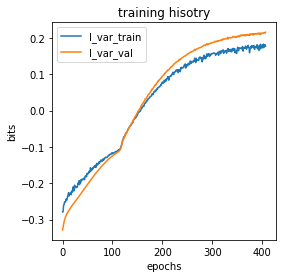

In [27]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
fig.savefig('pngs/Titeseq_MP/history.png',dpi=200,bbox_inches='tight')

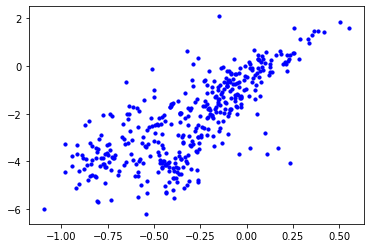

In [28]:
plt.scatter(theta_lc_init.ravel(),gpmap.weights[1].numpy().ravel(),c='blue',s=10)

In [29]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

# theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
# theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

# theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
# theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [30]:
phi = gpmap.x_to_phi(x_test)

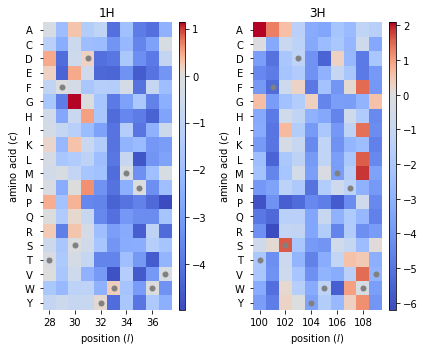

In [38]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight',facecolor='white')

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_32533/2877113002.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


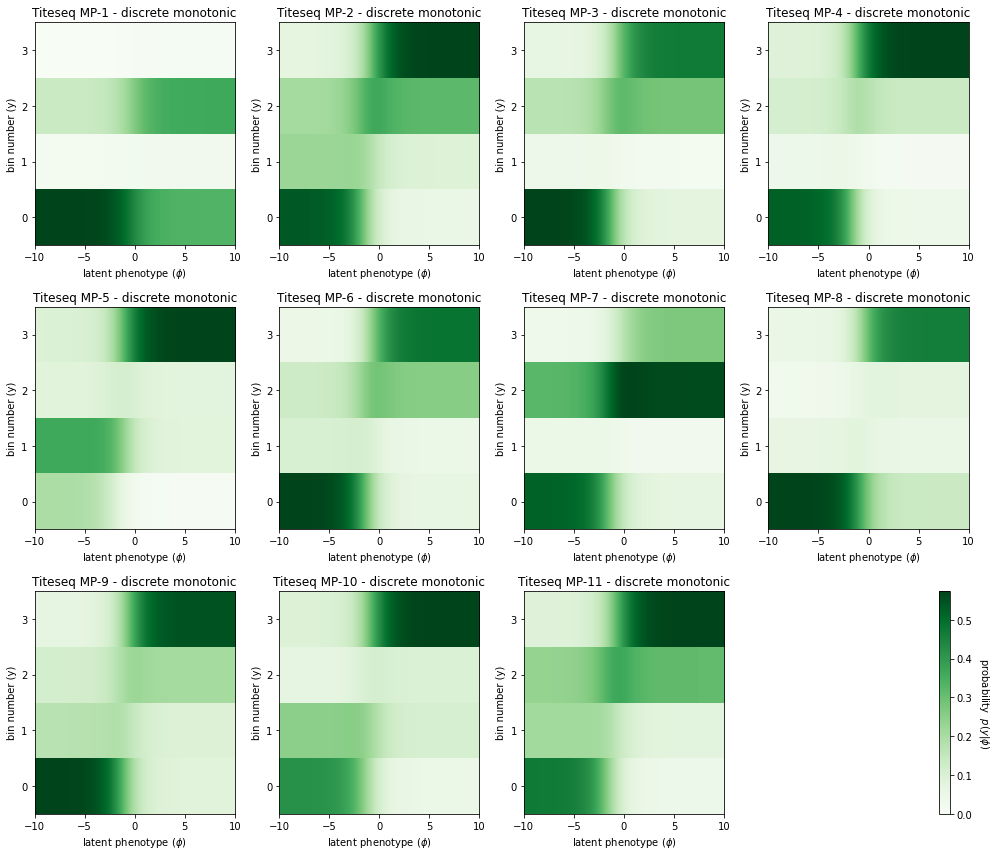

In [36]:
# Create grid in phi space
phi_lim = [-10, 10]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = TiteSeq_mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = TiteSeq_mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/Titeseq_MP/MPs.png',dpi=200,bbox_inches='tight')


In [39]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)

In [40]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [41]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [42]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)